<a href="https://colab.research.google.com/github/santossousa/TRANSFER-NCIA-DE-CONHECIMENTO-PARA-DETEC-O-AUTOM-TICA-DE-FAKE-NEWS-COM-APRENDIZAGEM-PROFUNDA/blob/main/classification_of__fake_news_NV_LOG_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [172]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
import itertools

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from numpy import mean
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


In [173]:
df = pd.read_csv('https://raw.githubusercontent.com/roneysco/Fake.br-Corpus/master/preprocessed/pre-processed.csv')
df.head()

,index,label,preprocessed_news
0,0,fake,katia abreu diz vai colocar expulsao moldura n...
1,1,fake,ray peita bolsonaro conservador fake entrevist...
2,2,fake,reinaldo azevedo desmascarado policia federal ...
3,3,fake,relatorio assustador bndes mostra dinheiro pub...
4,4,fake,radialista americano fala sobre pt vendem ilus...


In [174]:
fake = df[df.label == 'fake']
fake.head()

,index,label,preprocessed_news
0,0,fake,katia abreu diz vai colocar expulsao moldura n...
1,1,fake,ray peita bolsonaro conservador fake entrevist...
2,2,fake,reinaldo azevedo desmascarado policia federal ...
3,3,fake,relatorio assustador bndes mostra dinheiro pub...
4,4,fake,radialista americano fala sobre pt vendem ilus...


In [175]:
true = df[df.label == 'true']
true.head()

,index,label,preprocessed_news
3600,3600,true,podemos decidiu expulsar deputado federal carl...
3601,3601,true,bolsonaro liberal completo diz presidente psl ...
3602,3602,true,ministro stf libera andrea neves prisao domici...
3603,3603,true,apesar abundancia cresce preocupacao preservac...
3604,3604,true,harvard mit levarao dilma moro suplicy eua meg...


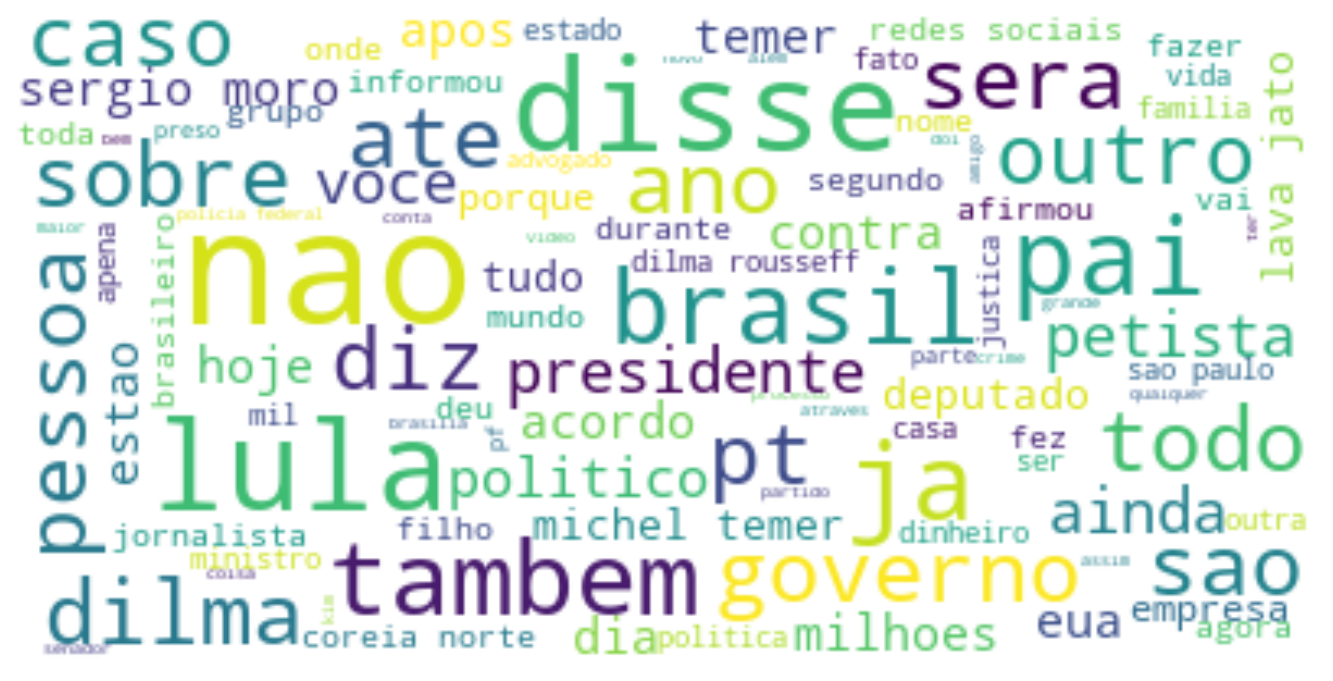

In [176]:

text = " ".join(review for review in fake.preprocessed_news)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

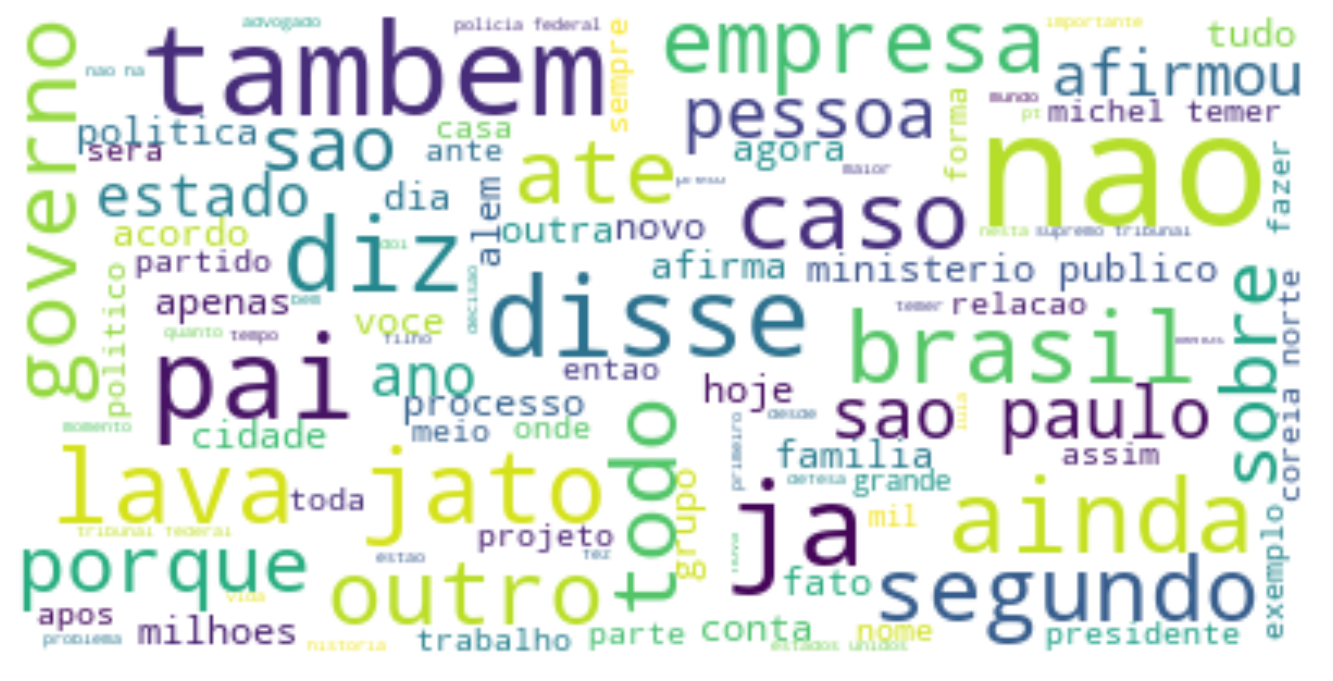

In [177]:

text = " ".join(review for review in true.preprocessed_news)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [178]:
df_Fake=df[['label','preprocessed_news']].groupby('label').count().reset_index()
df_Fake.columns=['label','count']
df_Fake['percentage']=(df_Fake['count']/df_Fake['count'].sum())*100
df_Fake

,label,count,percentage
0,fake,3600,50.0
1,true,3600,50.0


In [179]:
encode = {
            "label":     {"true": 0, "fake": 1}
         
         }

In [180]:
df = df.replace(encode)
df.head()


,index,label,preprocessed_news
0,0,1,katia abreu diz vai colocar expulsao moldura n...
1,1,1,ray peita bolsonaro conservador fake entrevist...
2,2,1,reinaldo azevedo desmascarado policia federal ...
3,3,1,relatorio assustador bndes mostra dinheiro pub...
4,4,1,radialista americano fala sobre pt vendem ilus...


In [181]:
df.sample(frac=1)

,index,label,preprocessed_news
333,333,1,urgente presidente senado sofreu isquemia dura...
2813,2813,1,policia federal vai investigar sitio lula refo...
906,906,1,video doria reforca promessa lula pessoa educa...
4089,4089,0,lula diz moro nunca intencao adquirir triplex ...
3362,3362,1,foguetes podem estar sendo preparados atacar e...
...,...,...,...
3863,3863,0,saiba mundo politico reagiu decisao temer nao ...
5988,5988,0,presidente nacional psdb senador tasso jereiss...
2801,2801,1,cunha volta ameacar planalto tenta barganhar m...
3165,3165,1,general manda recado stf abaixaram calcas cong...


In [182]:
X = df['preprocessed_news']
y = df['label']

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = None)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify = None)

In [184]:
X[0]

'katia abreu diz vai colocar expulsao moldura nao reclamar senadora katia abreu disse expulsao pmdb resultado acao cupula atual legenda segundo oportunista amanha vou botar moldura dourada expulsao porque maos onde veio atestado boa conduta curriculo pessoas expulsaram nao servem pais servem pais beneficios proprios disse katia abreu ue expulsao algo tao bom curriculo tanta choradeira katia sabemos motivo provavelmente katia nao valor pt partido ja deveria absorvido parece pt gostava katia somente ficasse entrincheirada dentro pmdb rebaixar demais resta katia ficar chorando pitangas todos cantos tempo ate momento pt nao cadastrou katia abreu fileiras situacao patetica agricultura dilma'

In [185]:

count_vectorizer = CountVectorizer()

In [186]:
def plot_confusion_matrix(cm, title='Confusion matrix'):
       
    plt.title(title)
    
    hmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [187]:
corpus = [
     'katia abreu diz vai colocar expulsao moldura nao reclamar senadora katia abreu disse expulsao pmdb resultado acao cupula atual.',
     'dilma finge solidariedade katia abreu nao convida pt dilma fez narrativa nesta sexta solidarizar senadora katia abreu expulsa pmdb',
     'katia abreu relatou nobre deputado citado acima fez questao indicar daniel goncalves filho cargo superintendente ministerio agricultura',
     
 ]

In [188]:
count_vectorizer.fit(corpus)

CountVectorizer()

In [189]:
count_vectorizer.get_feature_names_out()

array(['abreu', 'acao', 'acima', 'agricultura', 'atual', 'cargo',
       'citado', 'colocar', 'convida', 'cupula', 'daniel', 'deputado',
       'dilma', 'disse', 'diz', 'expulsa', 'expulsao', 'fez', 'filho',
       'finge', 'goncalves', 'indicar', 'katia', 'ministerio', 'moldura',
       'nao', 'narrativa', 'nesta', 'nobre', 'pmdb', 'pt', 'questao',
       'reclamar', 'relatou', 'resultado', 'senadora', 'sexta',
       'solidariedade', 'solidarizar', 'superintendente', 'vai'],
      dtype=object)

In [190]:
print("Vocabulary: ", count_vectorizer.vocabulary_)

Vocabulary:  {'katia': 22, 'abreu': 0, 'diz': 14, 'vai': 40, 'colocar': 7, 'expulsao': 16, 'moldura': 24, 'nao': 25, 'reclamar': 32, 'senadora': 35, 'disse': 13, 'pmdb': 29, 'resultado': 34, 'acao': 1, 'cupula': 9, 'atual': 4, 'dilma': 12, 'finge': 19, 'solidariedade': 37, 'convida': 8, 'pt': 30, 'fez': 17, 'narrativa': 26, 'nesta': 27, 'sexta': 36, 'solidarizar': 38, 'expulsa': 15, 'relatou': 33, 'nobre': 28, 'deputado': 11, 'citado': 6, 'acima': 2, 'questao': 31, 'indicar': 21, 'daniel': 10, 'goncalves': 20, 'filho': 18, 'cargo': 5, 'superintendente': 39, 'ministerio': 23, 'agricultura': 3}


In [191]:
vector = count_vectorizer.transform(corpus)

In [192]:
print(vector.toarray())

[[2 1 0 0 1 0 0 1 0 1 0 0 0 1 1 0 2 0 0 0 0 0 2 0 1 1 0 0 0 1 0 0 1 0 1 1
  0 0 0 0 1]
 [2 0 0 0 0 0 0 0 1 0 0 0 2 0 0 1 0 1 0 1 0 0 2 0 0 1 1 1 0 1 1 0 0 0 0 1
  1 1 1 0 0]
 [1 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0 0
  0 0 0 1 0]]


In [193]:
def k_folds_validation(model, X,y,cv,vectorizer):
  scorings = ['accuracy', 'f1','precision','recall']
  scores = cross_validate(model ,vectorizer.fit_transform(X), y, scoring=scorings, cv=cv, n_jobs=-1,return_estimator=True)
	# return scores
  return scores['estimator'], mean(scores['test_accuracy']),mean(scores['test_f1']),mean(scores['test_precision']),mean(scores['test_recall'])


In [194]:
folds = range(2,11)

In [195]:
def best_model(models,vectorizer):
  best_model = None
  best_acc = 0
  for i in range(len(models)):
    acc = models[i].score(vectorizer.transform(X_val),y_val)
    if acc > best_acc:
      best_model = models[i]
      best_acc = acc

  return best_model

In [196]:
def models_folds(model,vectorizer):
  best_models = None
  mean_best = 0
  for k in folds:
    cv = KFold(n_splits=k, shuffle=True, random_state=1)
   
    models, accuracy_mean, f1_score_mean, precision_mean, recall_mean  = k_folds_validation(model,X_train,y_train,cv,vectorizer)
    print('> folds=%d, accuracy=%.3f , F1-score=%.3f, precision=%.3f, recall=%.3f' % (k,accuracy_mean, f1_score_mean, precision_mean,recall_mean))
    if accuracy_mean > mean_best:
      best_models = models
      mean_best = accuracy_mean
  return best_model(best_models,vectorizer)

In [197]:
%time

models = [('LR',LogisticRegression(random_state=42)),('NB', MultinomialNB()),('SVM', SVC(kernel='linear'))]

for name, model in models:
  print(name)
  if name == 'LR':
    lr = models_folds(model,count_vectorizer)
  elif name == 'NB':
    nb = models_folds(model,count_vectorizer)
  elif name == 'SVM':
    svc = models_folds(model,count_vectorizer)
  


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 11.7 µs
LR
> folds=2, accuracy=0.960 , F1-score=0.961, precision=0.943, recall=0.979
> folds=3, accuracy=0.961 , F1-score=0.962, precision=0.945, recall=0.980
> folds=4, accuracy=0.962 , F1-score=0.963, precision=0.949, recall=0.978
> folds=5, accuracy=0.963 , F1-score=0.964, precision=0.950, recall=0.977
> folds=6, accuracy=0.964 , F1-score=0.965, precision=0.952, recall=0.978
> folds=7, accuracy=0.964 , F1-score=0.965, precision=0.952, recall=0.978
> folds=8, accuracy=0.963 , F1-score=0.964, precision=0.952, recall=0.977
> folds=9, accuracy=0.964 , F1-score=0.965, precision=0.953, recall=0.977
> folds=10, accuracy=0.963 , F1-score=0.965, precision=0.952, recall=0.978
NB
> folds=2, accuracy=0.726 , F1-score=0.640, precision=0.961, recall=0.480
> folds=3, accuracy=0.775 , F1-score=0.727, precision=0.943, recall=0.591
> folds=4, accuracy=0.798 , F1-score=0.762, precision=0.943, recall=0.640
> folds=5, accuracy=0.807 , F1-score=0.77

In [198]:
pred_svm_test = svc.predict(count_vectorizer.transform(X_test))
prediction_logistic_test = lr.predict(count_vectorizer.transform(X_test))



**Classification using Navie Baye's Classifier**


In [199]:
prediction = nb.predict(count_vectorizer.transform(X_test))
cm_NB = confusion_matrix(y_test, prediction)
df_NB = pd.DataFrame(cm_NB, index=np.unique(y_test), columns=np.unique(y_test))

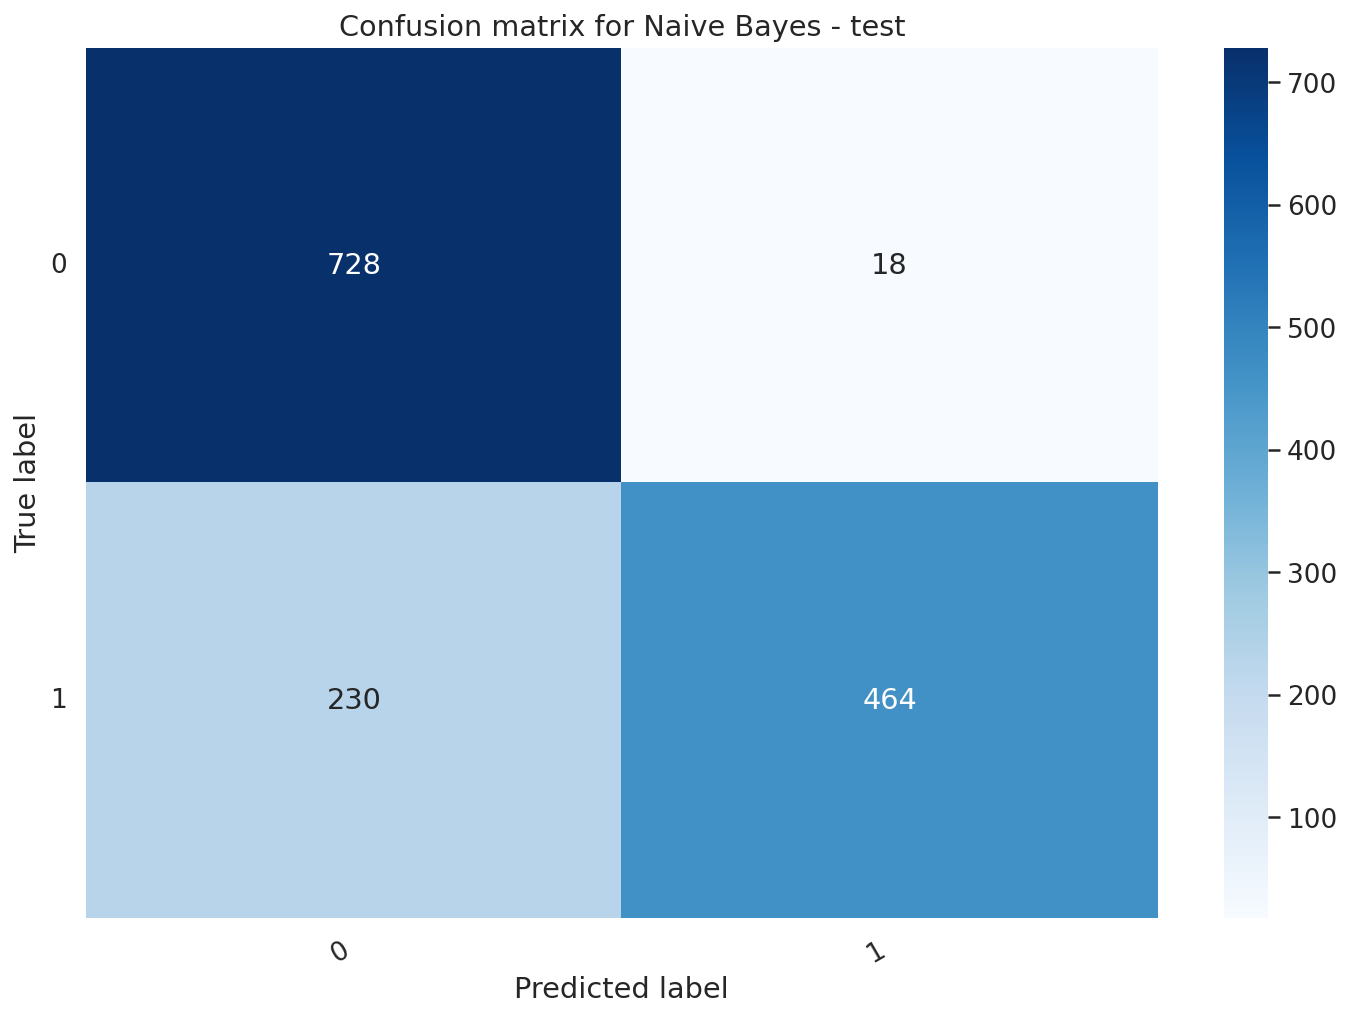

In [200]:
plt.figure()
plot_confusion_matrix(df_NB,title='Confusion matrix for Naive Bayes - test')

In [201]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.76      0.98      0.85       746
           1       0.96      0.67      0.79       694

    accuracy                           0.83      1440
   macro avg       0.86      0.82      0.82      1440
weighted avg       0.86      0.83      0.82      1440



**Classification using Logistic Regression Model**

In [202]:
prediction_logistic_test = lr.predict(count_vectorizer.transform(X_test))
cm_lR = confusion_matrix(y_test, prediction_logistic_test)
df_LR = pd.DataFrame(cm_lR, index=np.unique(y_test), columns=np.unique(y_test))


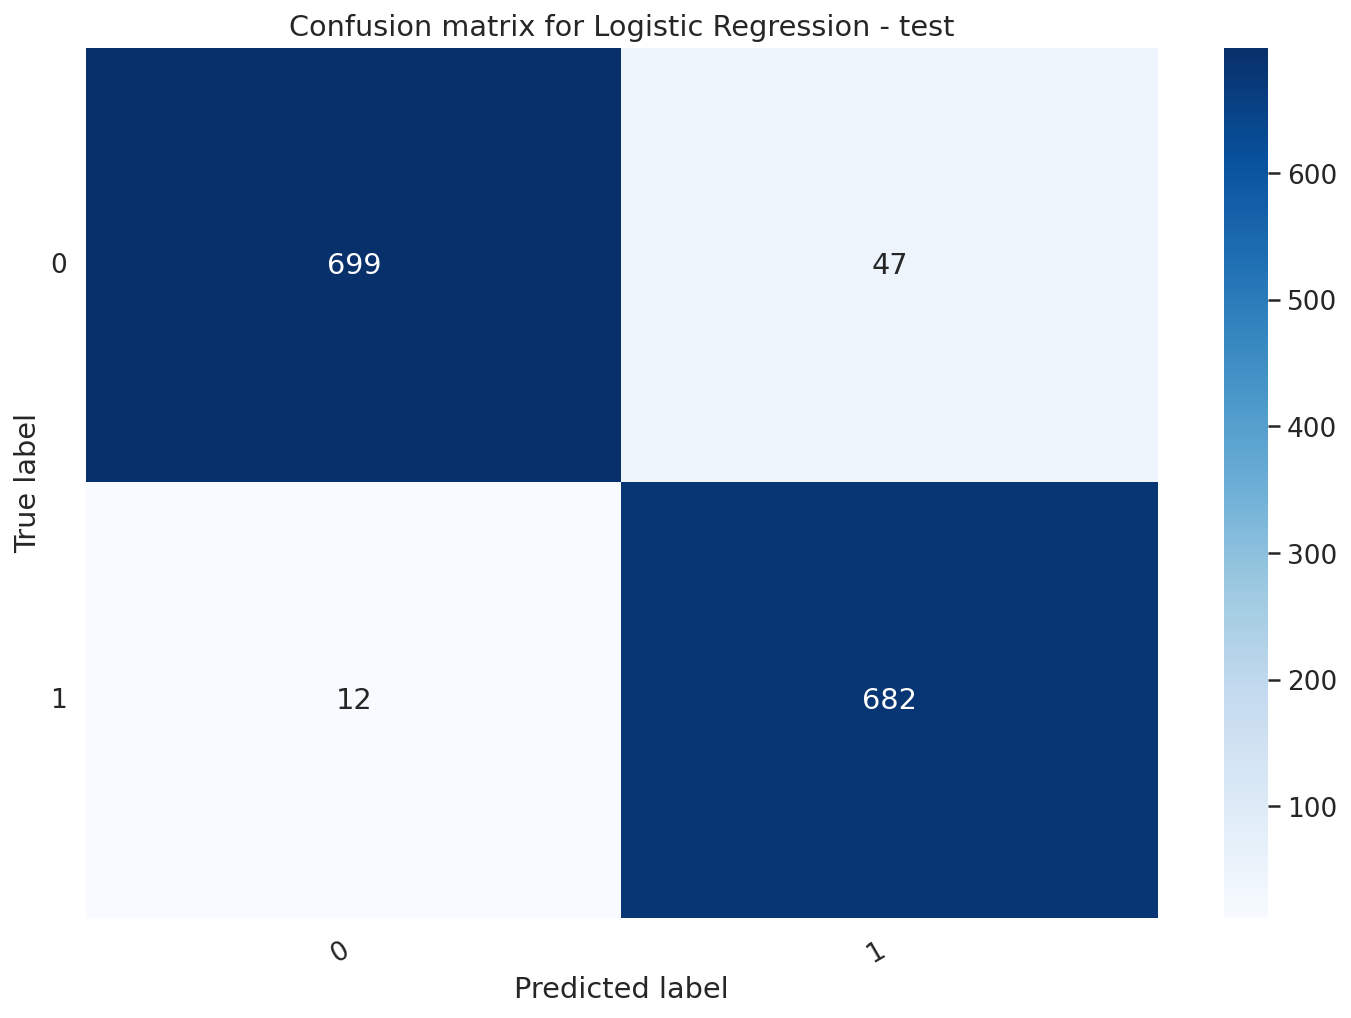

In [203]:
plt.figure()
plot_confusion_matrix(df_LR,
                      title='Confusion matrix for Logistic Regression - test')

In [204]:
print(classification_report(y_test, prediction_logistic_test))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       746
           1       0.94      0.98      0.96       694

    accuracy                           0.96      1440
   macro avg       0.96      0.96      0.96      1440
weighted avg       0.96      0.96      0.96      1440



**Classification using suport vector machine**

In [205]:
pred_svm_test = svc.predict(count_vectorizer.transform(X_test))
cm_SVC = confusion_matrix(y_test, pred_svm_test)
df_SVC = pd.DataFrame(cm_SVC, index=np.unique(y_test), columns=np.unique(y_test))


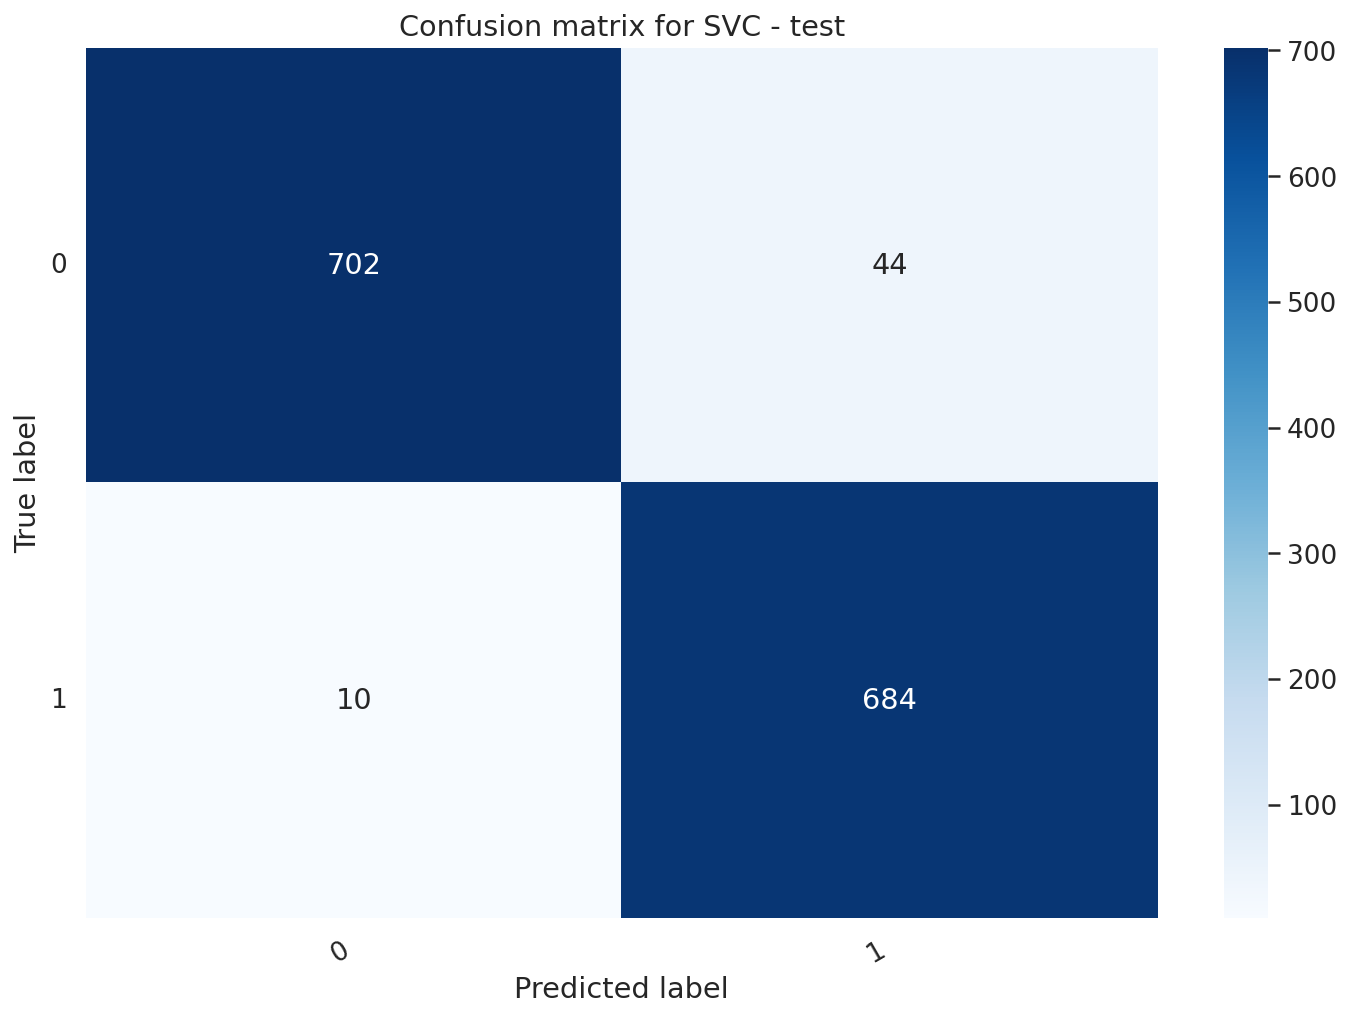

In [206]:
plt.figure()
plot_confusion_matrix(df_SVC,
                      title='Confusion matrix for SVC - test')

In [207]:
print(classification_report(y_test, pred_svm_test))


              precision    recall  f1-score   support

           0       0.99      0.94      0.96       746
           1       0.94      0.99      0.96       694

    accuracy                           0.96      1440
   macro avg       0.96      0.96      0.96      1440
weighted avg       0.96      0.96      0.96      1440



TF-IDF method:

**Naive Baye's**

In [208]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

vectorizer = TfidfVectorizer()



In [209]:
models_tf = [('NB',MultinomialNB()),('LR',LogisticRegression(random_state=42)),('SVM',SVC(kernel='sigmoid'))]

In [210]:
%time
for name, model in models_tf:
  print(name)
  if name == 'LR':
    lr = models_folds(model,vectorizer)
  elif name == 'NB':
    nb = models_folds(model,vectorizer)
  elif name == 'SVM':
    svc = models_folds(model,vectorizer)
  

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs
NB
> folds=2, accuracy=0.567 , F1-score=0.256, precision=0.997, recall=0.147
> folds=3, accuracy=0.585 , F1-score=0.307, precision=0.998, recall=0.182
> folds=4, accuracy=0.597 , F1-score=0.343, precision=0.996, recall=0.208
> folds=5, accuracy=0.603 , F1-score=0.359, precision=0.994, recall=0.220
> folds=6, accuracy=0.606 , F1-score=0.367, precision=0.994, recall=0.225
> folds=7, accuracy=0.607 , F1-score=0.369, precision=0.994, recall=0.227
> folds=8, accuracy=0.611 , F1-score=0.379, precision=0.995, recall=0.235
> folds=9, accuracy=0.613 , F1-score=0.384, precision=0.994, recall=0.239
> folds=10, accuracy=0.615 , F1-score=0.390, precision=0.995, recall=0.243
LR
> folds=2, accuracy=0.936 , F1-score=0.938, precision=0.911, recall=0.967
> folds=3, accuracy=0.938 , F1-score=0.941, precision=0.918, recall=0.964
> folds=4, accuracy=0.941 , F1-score=0.943, precision=0.921, recall=0.967
> folds=5, accuracy=0.941 , F1-score=0.94

**NB**

In [211]:
prediction = nb.predict(vectorizer.transform(X_test))
#Confusion matrix
cm_NB_ = confusion_matrix(y_test, prediction)
df_NB_ = pd.DataFrame(cm_NB_, index=np.unique(y_test), columns=np.unique(y_test))


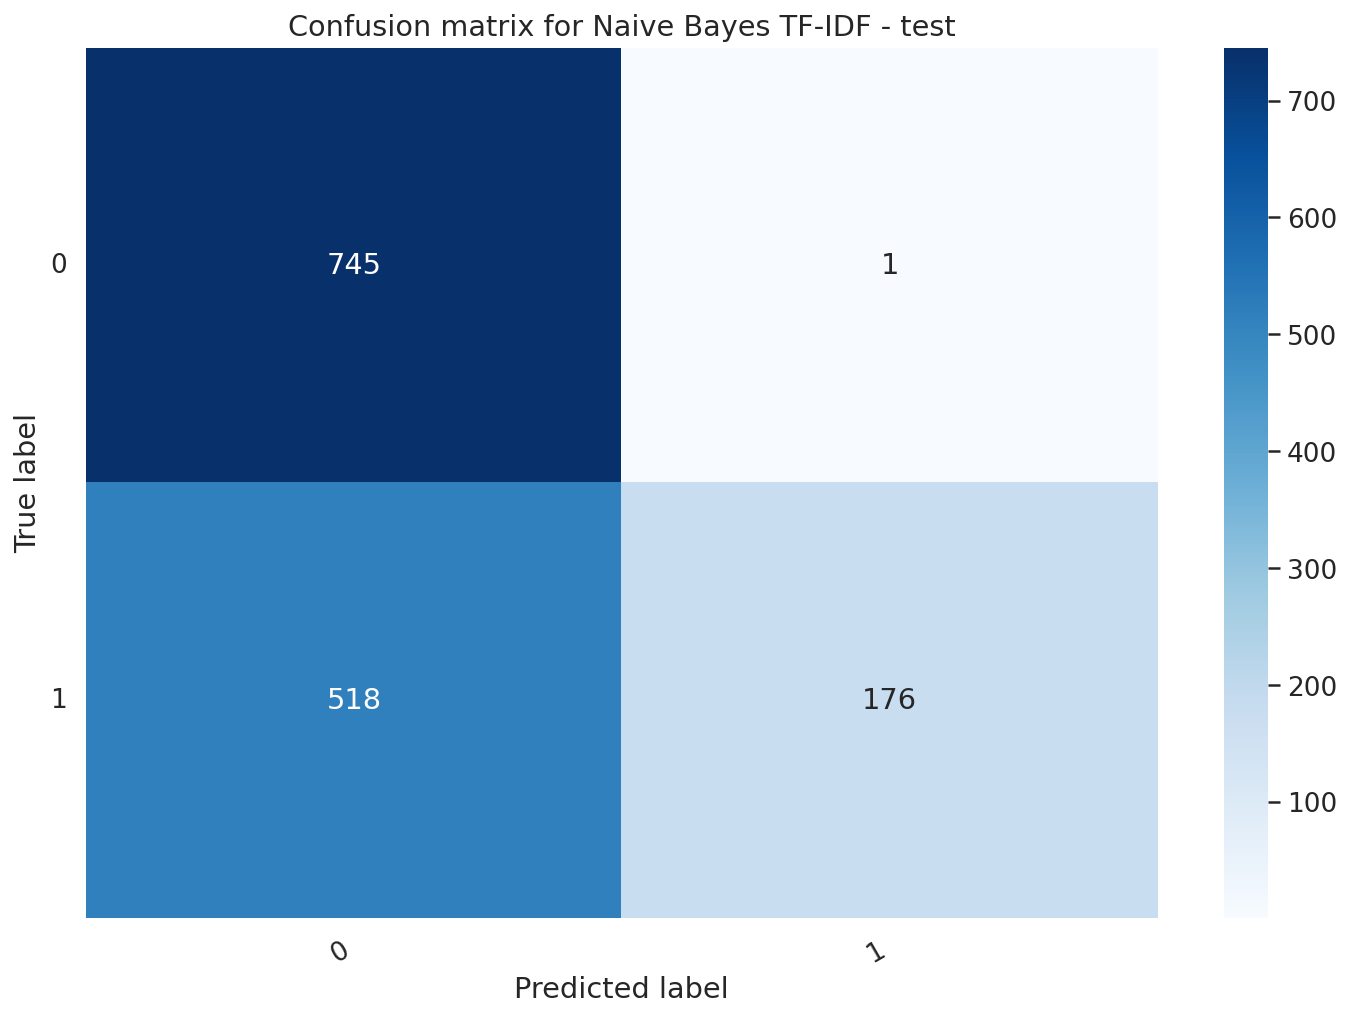

In [212]:
plt.figure()
plot_confusion_matrix(df_NB_,
                      title='Confusion matrix for Naive Bayes TF-IDF - test')

In [213]:
print(classification_report(y_test, prediction))


              precision    recall  f1-score   support

           0       0.59      1.00      0.74       746
           1       0.99      0.25      0.40       694

    accuracy                           0.64      1440
   macro avg       0.79      0.63      0.57      1440
weighted avg       0.78      0.64      0.58      1440



**LR**

In [214]:
prediction_logistic_test = lr.predict(vectorizer.transform(X_test))
#Confusion matrix
cm_LR_ = confusion_matrix(y_test, prediction_logistic_test)
df_LR_ = pd.DataFrame(cm_LR_, index=np.unique(y_test), columns=np.unique(y_test))


In [215]:
df_LR_ = pd.DataFrame(cm_LR_, index=np.unique(y_test), columns=np.unique(y_test))

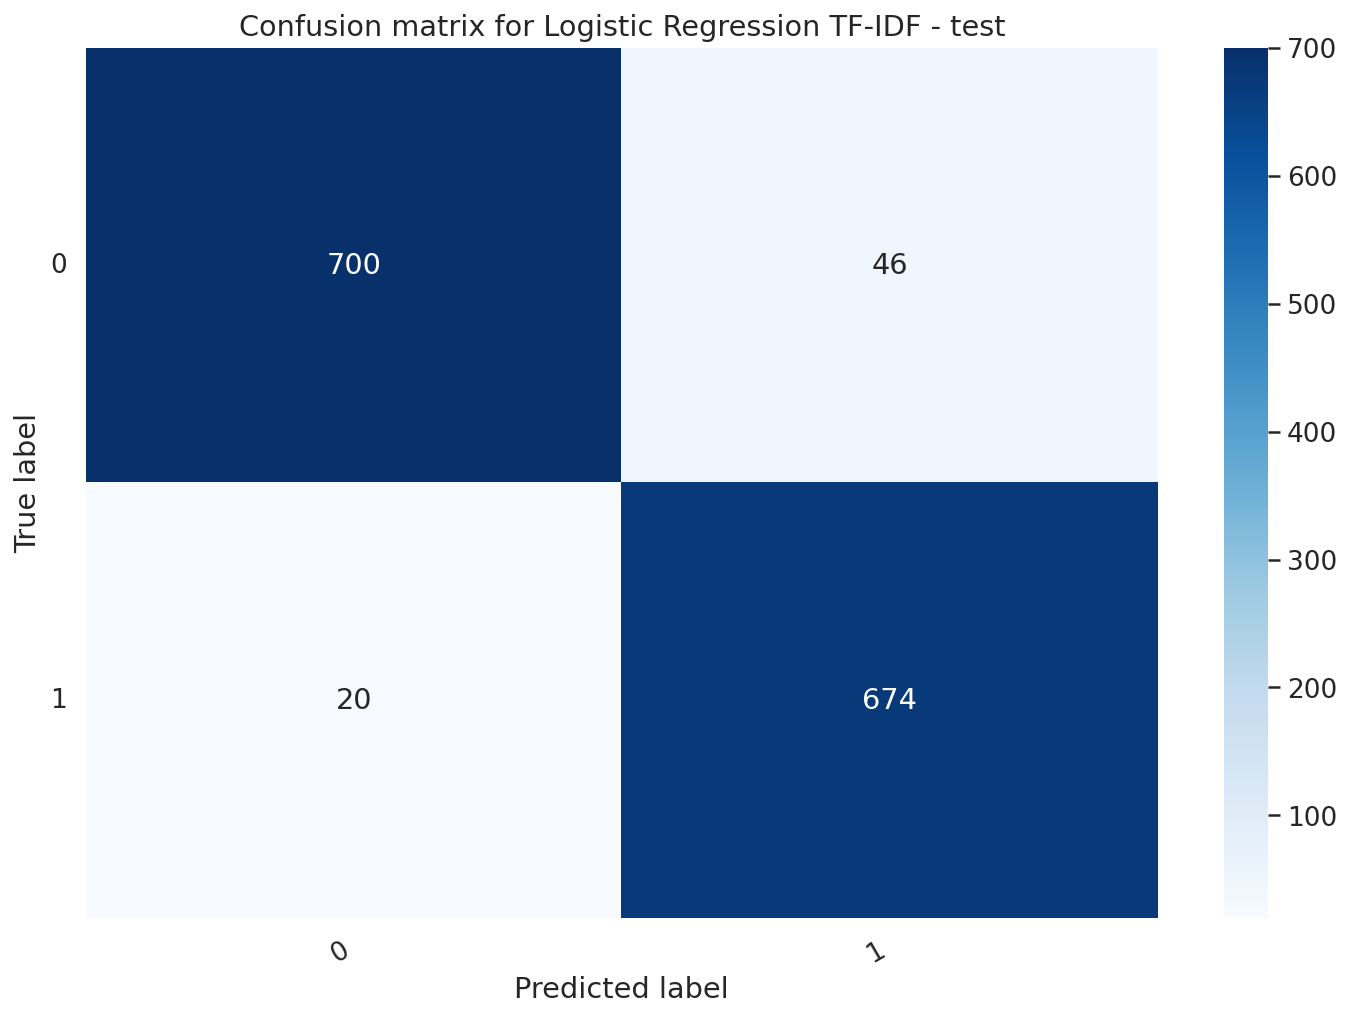

In [216]:
plt.figure()
plot_confusion_matrix(df_LR_,
                      title='Confusion matrix for Logistic Regression TF-IDF - test')

In [217]:
print(classification_report(y_test, prediction_logistic_test))


              precision    recall  f1-score   support

           0       0.97      0.94      0.95       746
           1       0.94      0.97      0.95       694

    accuracy                           0.95      1440
   macro avg       0.95      0.95      0.95      1440
weighted avg       0.95      0.95      0.95      1440



**SVC**

In [218]:
pred_svm_test = svc.predict(vectorizer.transform(X_test))
cm_SVC_ = confusion_matrix(y_test, pred_svm_test)
df_SVC_ = pd.DataFrame(cm_SVC_, index=np.unique(y_test), columns=np.unique(y_test))


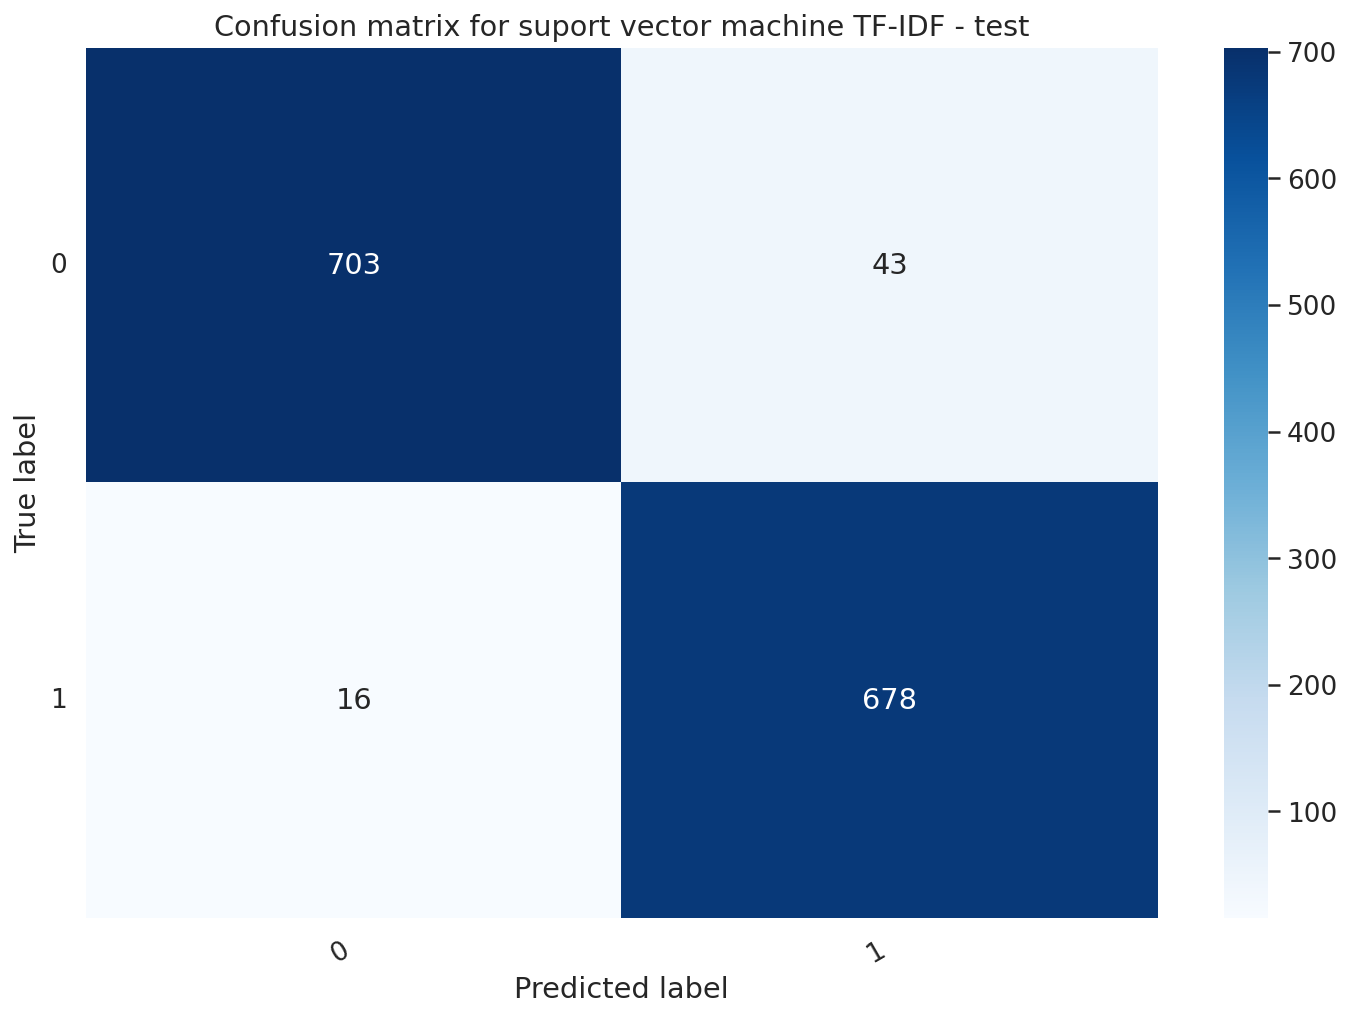

In [219]:
plt.figure()
plot_confusion_matrix(df_SVC_,
                      title='Confusion matrix for suport vector machine TF-IDF - test')

In [220]:
print(classification_report(y_test, pred_svm_test))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       746
           1       0.94      0.98      0.96       694

    accuracy                           0.96      1440
   macro avg       0.96      0.96      0.96      1440
weighted avg       0.96      0.96      0.96      1440

